## LASSO logistic regression
In the given notebook I want to verify how efficient will be basic logistic regression with lasso regularization. As it is known this method is capable of basic feature selection

In [14]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression


import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from sklearn.model_selection import train_test_split

import numpy as np

random.seed(44)
np.random.seed(44)

import sys
sys.path.append('..')

In [6]:
x_train = np.load("../../data/x_train.npy")
y_train = np.load("../../data/y_train.npy")

x_val = np.load("../../data/x_val.npy")
y_val = np.load("../../data/y_val.npy")

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)

In [33]:
basic_lasso = LogisticRegression(penalty="l1", solver="saga")

basic_lasso.fit(x_train, y_train)

y_pred = basic_lasso.predict(x_val)

print(f"Accuracy of basic LASSO model: {np.mean(y_pred == y_val)}")

Accuracy of basic LASSO model: 0.511


In [34]:
print(f"Number of features used by the model: {np.sum(basic_lasso.coef_ != 0)}")  # too many features
print(f"R^2 of model: {r2_score(y_val, y_pred)}") # very poor R2 xd

Number of features used by the model: 473
R^2 of model: -0.9560078240312964


## crossvalidation for best hyperparameters

In [86]:
penalty = "l1"
solvers = ["liblinear", "saga"]
Cs = 10 ** np.arange(-2, 3, step = 0.25)

print(f"Used lambda values: {1 / Cs}")


cv_lasso = LogisticRegressionCV(penalty=penalty, solver=solvers[0], Cs=Cs, cv = 5, verbose=1, n_jobs = 5)

cv_lasso.fit(x_train, y_train)

Used lambda values: [1.00000000e+02 5.62341325e+01 3.16227766e+01 1.77827941e+01
 1.00000000e+01 5.62341325e+00 3.16227766e+00 1.77827941e+00
 1.00000000e+00 5.62341325e-01 3.16227766e-01 1.77827941e-01
 1.00000000e-01 5.62341325e-02 3.16227766e-02 1.77827941e-02
 1.00000000e-02 5.62341325e-03 3.16227766e-03 1.77827941e-03]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    6.5s remaining:    9.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   10.5s finished


LogisticRegressionCV(Cs=array([1.00000000e-02, 1.77827941e-02, 3.16227766e-02, 5.62341325e-02,
       1.00000000e-01, 1.77827941e-01, 3.16227766e-01, 5.62341325e-01,
       1.00000000e+00, 1.77827941e+00, 3.16227766e+00, 5.62341325e+00,
       1.00000000e+01, 1.77827941e+01, 3.16227766e+01, 5.62341325e+01,
       1.00000000e+02, 1.77827941e+02, 3.16227766e+02, 5.62341325e+02]),
                     cv=5, n_jobs=5, penalty='l1', solver='liblinear',
                     verbose=1)

In [87]:
y_pred = cv_lasso.predict(x_val)
print(f"Accuracy: {np.mean(y_pred == y_val)}")
print(f"Number of features used by the model: {np.sum(cv_lasso.coef_ != 0)}")  # too many features
print(f"R^2 of model: {r2_score(y_val, y_pred)}") # very poor R2 xd

Accuracy: 0.49
Number of features used by the model: 40
R^2 of model: -1.0400081600326403


In [88]:
cv_lasso.C_

array([0.01778279])

In [94]:
coefs = (cv_lasso.coefs_paths_[1.0] != 0).mean(axis = 0)

c:\Users\tymot\Documents\studia\aml\pro\adv_ml_project_2\.venv\Lib\site-packages\matplotlib\scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


Text(1, 60, '50 features')

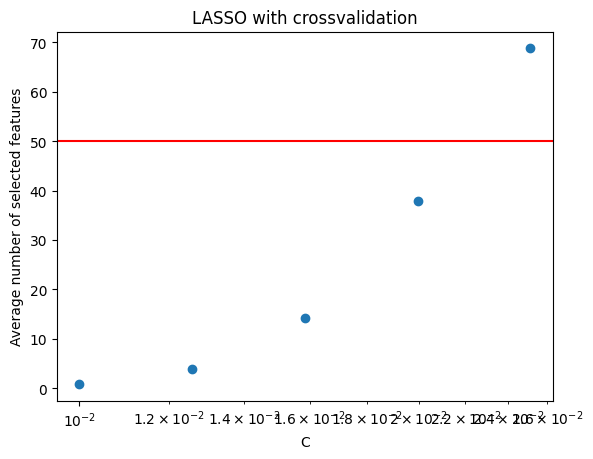

In [143]:
coefs = (cv_lasso.coefs_paths_[1.0] != 0).mean(axis = 0)

coefs.sum(axis = 1)

plt.scatter(Cs, coefs.sum(axis = 1))
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Average number of selected features")
plt.title("LASSO with crossvalidation")

plt.axhline(50, 0, 1000, color = "red")
plt.annotate("50 features", (1, 60))

in order for our final selection to have any sense, we need to select at most 50 features. In case we select 50 features we have absolutely no income. Therefore we need to investigate values of C parameter smaller than 0.05

In [210]:
penalty = "l1"
solvers = ["liblinear", "saga"]
Cs = 10 ** np.arange(-2, -1.5, step = 0.05)

print(f"Used lambda values: {1 / Cs}")


cv_lasso = LogisticRegressionCV(penalty=penalty, solver=solvers[0], Cs=Cs, cv = 5, verbose=1, n_jobs = 5)

cv_lasso.fit(x_train, y_train)

Used lambda values: [100.          89.12509381  79.43282347  70.79457844  63.09573445
  56.23413252  50.11872336  44.66835922  39.81071706  35.48133892]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.0s finished


LogisticRegressionCV(Cs=array([0.01      , 0.01122018, 0.01258925, 0.01412538, 0.01584893,
       0.01778279, 0.01995262, 0.02238721, 0.02511886, 0.02818383]),
                     cv=5, n_jobs=5, penalty='l1', solver='liblinear',
                     verbose=1)

c:\Users\tymot\Documents\studia\aml\pro\adv_ml_project_2\.venv\Lib\site-packages\matplotlib\scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


Text(1, 60, '50 features')

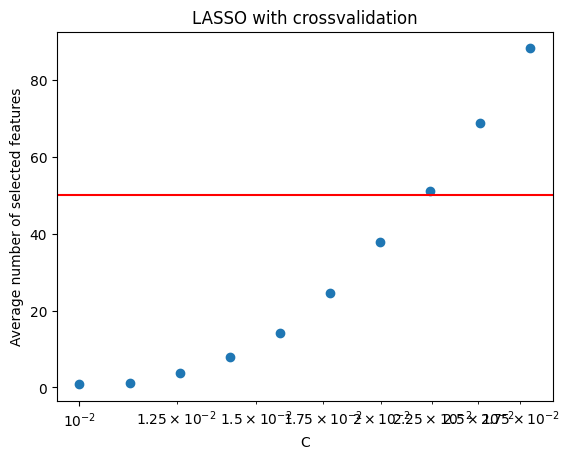

In [211]:
coefs = (cv_lasso.coefs_paths_[1.0] != 0).mean(axis = 0)

coefs.sum(axis = 1)

plt.scatter(Cs, coefs.sum(axis = 1))
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Average number of selected features")
plt.title("LASSO with crossvalidation")

plt.axhline(50, 0, 1000, color = "red")
plt.annotate("50 features", (1, 60))

In [212]:
y_pred = cv_lasso.predict(x_val)
print(f"Accuracy: {np.mean(y_pred == y_val)}")
print(f"Number of features used by the model: {np.sum(cv_lasso.coef_ != 0)}")  # too many features
print(f"R^2 of model: {r2_score(y_val, y_pred)}") # very poor R2 xd


Accuracy: 0.49
Number of features used by the model: 40
R^2 of model: -1.0400081600326403


### Elasticnet

In [198]:
penalty = "elasticnet"
solvers = ["liblinear", "saga"]
Cs = np.array([0.01])
l1_ratios = np.arange(0, 1, step = 0.1)

print(f"Used lambda values: {1 / Cs}")


cv_elastic = LogisticRegressionCV(penalty=penalty, solver=solvers[1], Cs=Cs, cv = 5, verbose=1, l1_ratios=l1_ratios, n_jobs = 5)

cv_elastic.fit(x_train, y_train)

Used lambda values: [100.]


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 23 epochs took 0 seconds
convergence after 19 epochs took 0 seconds
convergence after 18 epochs took 0 seconds
convergence after 20 epochs took 0 seconds
convergence after 29 epochs took 0 seconds
convergence after 22 epochs took 0 seconds
convergence after 16 epochs took 0 seconds
convergence after 17 epochs took 0 seconds
convergence after 21 epochs took 0 seconds
convergence after 17 epochs took 1 seconds
convergence after 24 epochs took 1 seconds
convergence after 21 epochs took 1 seconds
convergence after 22 epochs took 1 seconds
convergence after 22 epochs took 1 seconds
convergence after 20 epochs took 0 seconds
convergence after 17 epochs took 0 seconds
convergence after 17 epochs took 0 seconds
convergence after 17 epochs took 0 seconds
convergence after 18 epochs took 0 seconds
convergence after 18 epochs took 0 seconds
convergence after 23 epochs took 0 seconds
convergence after 21 epochs took 1 seconds
convergence after 21 epochs took 1 seconds
convergence

[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    2.9s


convergence after 19 epochs took 0 seconds
convergence after 21 epochs took 0 seconds
convergence after 19 epochs took 0 seconds
convergence after 19 epochs took 0 seconds
convergence after 29 epochs took 0 seconds
convergence after 19 epochs took 0 seconds
convergence after 16 epochs took 0 seconds
convergence after 17 epochs took 0 seconds
convergence after 20 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:    3.5s finished


LogisticRegressionCV(Cs=array([0.01]), cv=5,
                     l1_ratios=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                     n_jobs=5, penalty='elasticnet', solver='saga', verbose=1)

In [201]:
y_pred = cv_elastic.predict(x_val)
print(f"Accuracy: {np.mean(y_pred == y_val)}")
print(f"Number of features used by the model: {np.sum(cv_elastic.coef_ != 0)}")  # too many features
print(f"R^2 of model: {r2_score(y_val, y_pred)}") # very poor R2 xd


Accuracy: 0.502
Number of features used by the model: 55
R^2 of model: -0.9920079680318723


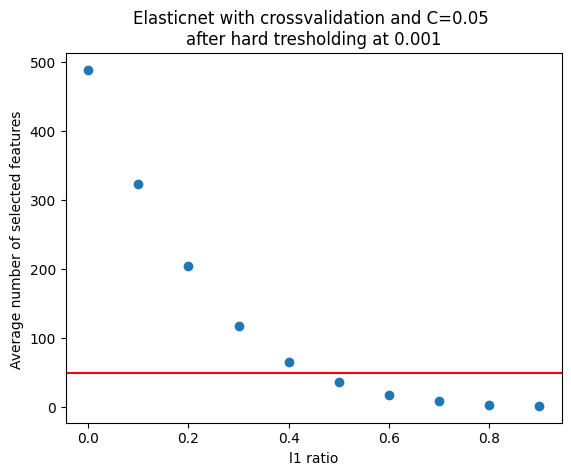

In [202]:
treshold = 0.001
coefs = (np.abs(cv_elastic.coefs_paths_[1.0]) > treshold).mean(axis = 0)[0]

plt.scatter(l1_ratios, coefs.sum(axis = 1))
plt.xlabel("l1 ratio")
plt.ylabel("Average number of selected features ")
plt.title(f"Elasticnet with crossvalidation and C=0.05 \nafter hard tresholding at {treshold}")

plt.annotate("50 features", (1, 60))
plt.axhline(50, 0, 1000, color = "red")


### Selected features
We need to investigate which features were selected by our method

In [289]:

treshold = 0.001
elastic_coefs = (np.abs(cv_elastic.coefs_paths_[1.0]) > treshold).mean(axis = 0)[0]
elastic_feature_importance = elastic_coefs.sum(axis = 0)

# now we can investigate which features were considered the most important

importance_treshold = 3
elastic_indexes = np.where(elastic_feature_importance > importance_treshold)[0]
print(elastic_indexes)

[ 10  20  21  24  29  34  35  36  38  39  47  48  57  60  64  66  67  75
  76  77  79  80  84  89  94  98 101 105 108 111 112 117 118 139 148 151
 152 155 156 157 170 172 175 178 181 184 187 189 191 197 198 199 200 203
 209 210 214 215 216 220 227 228 240 249 250 252 253 256 259 260 266 270
 273 281 283 285 288 296 301 303 304 306 308 311 316 317 321 323 324 326
 327 328 329 333 335 336 337 339 343 349 351 355 357 360 363 373 376 380
 383 387 396 399 403 409 412 415 416 422 424 439 442 443 445 458 466 471
 472 476 481 484 487 489 498 500]


In [290]:

treshold = 0.001
lasso_coefs = (np.abs(cv_lasso.coefs_paths_[1.0]) > treshold).mean(axis = 0)
lasso_feature_importance = lasso_coefs.sum(axis = 0)

# now we can investigate which features were considered the most important

importance_treshold = 2
lasso_indexes = np.where(lasso_feature_importance > importance_treshold)[0]
print(lasso_indexes)

[ 20  21  35  47  57  60  75  80  89  98 105 155 178 191 210 220 227 228
 240 252 285 288 296 303 306 308 321 323 324 327 328 335 343 351 357 360
 399 403 409 412 439 458 466 471 476 489 498]


In [291]:
total_indexes = list(set(lasso_indexes).intersection(set(elastic_indexes)))
print(f"Total selected features: {len(total_indexes)}")

Total selected features: 47


interestingly similar features were choosen. Now lets train some different model on the given features

In [292]:
lr = LogisticRegression()
X_selected = x_train[:, total_indexes]
lr.fit(X_selected, y_train)
y_pred = lr.predict(x_val[:, total_indexes])
print(f"Accuracy: {np.mean(y_pred == y_val)}")

Accuracy: 0.508


In [293]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=44)
rf.fit(x_train[:, total_indexes], y_train)
y_pred = rf.predict(x_val[:, total_indexes])
print(f"Accuracy: {np.mean(y_pred == y_val)}")

Accuracy: 0.534
